<a href="https://colab.research.google.com/github/FahmidaAkterShimu/Final-Project-using-NLP/blob/main/Hate_Speech_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Detection using LSTM**

In [38]:
# Importing libraries
import pandas as pd
import spacy
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/labeled_data.csv')

In [ ]:
df.shape

(24783, 7)

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [ ]:
# 1. DELETING UNWANTED COLUMNS
df.drop(columns = ['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'],
        inplace = True)

In [ ]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# 2. CHECKING FOR NULL VALUES
df.isna().sum()

,0
class,0
tweet,0


In [ ]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [ ]:
df['tweet'].iloc[100]

'"@ClicquotSuave: LMAOOOOOOOOOOO this nigga @Krillz_Nuh_Care http://t.co/AAnpSUjmYI" &lt;bitch want likes for some depressing shit..foh'

In [ ]:
df['tweet'].iloc[1000]

'&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;"@betysweetcocker: That pussy is just....&#128561; imma assume she just had a baby like..the day before"'

In [ ]:
# 3. REPLACING SYMBOLS AND NUMBERS FROM TEXT
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex = True)

In [ ]:
df.head()

,class,tweet,processed_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...


In [ ]:
df['processed_tweet'].iloc[1000]

'                                                                 betysweetcocker  That pussy is just              imma assume she just had a baby like  the day before '

In [ ]:
# 4. REPLACING MULTIPLE WHITESPACE CHARACTERS WITH SINGLE ONE
df['processed_tweet_2'] = df['processed_tweet'].str.replace(r'[\s]+', ' ', regex = True)

In [ ]:
df.head()

,class,tweet,processed_tweet,processed_tweet_2
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...,RT mayasolovely As a woman you shouldn t comp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...,RT C G Anderson viva based she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [ ]:
df['processed_tweet_2'].iloc[1000]

' betysweetcocker That pussy is just imma assume she just had a baby like the day before '

In [ ]:
# Deleting unwanted columns
df.drop(columns = ['tweet', 'processed_tweet'], inplace = True)

In [ ]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [ ]:
# 5. REPLACING THE TARGET VALUES
# df['class'].replace({0 : 'hate', 1 : 'offensive', 2 : 'neither'}, inplace = True)

In [ ]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [ ]:
# Load out spacy modeule
nlp = spacy.load('en_core_web_sm')

In [ ]:
# 6. LEMMATIZATION
def lemmatization(text):
  doc = nlp(text)
  lemmaList = [word.lemma_ for word in doc]
  return ' '.join(lemmaList)

In [31]:
df['lemma_tweet'] = df['processed_tweet_2'].apply(lemmatization)

In [32]:
df.head()

,class,processed_tweet_2,lemma_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...


In [33]:
df['processed_tweet_2'].iloc[67]

' Allyhaaaaa Lemmie eat a Oreo amp do these dishes One oreo Lol'

In [34]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [36]:
# 7. REMOVING STOPWORDS
def remove_stopwords(text):
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return ' '.join(no_stopwords_list)

In [ ]:
df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [ ]:
df['lemma_tweet'].iloc[67]

In [ ]:
df['final_tweet'].iloc[67]

In [ ]:
df.head()

In [ ]:
# 8. ONE - HOT REPRESENTATION

vocab_size = 10000
one_hot_representation = [one_hot(words, vocab_size) for words in df['final_tweet']]

In [ ]:
df['final_tweet'].iloc[0]

In [ ]:
one_hot_representation[100]

In [37]:
# 9. PADDING AND EMBEDDING

sentence_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding='pre', maxlen = sentence_length)

NameError: name 'one_hot_representation' is not defined

In [ ]:
embedded_tweet[0]

In [ ]:
for i in range (0,4):
  print(embedded_tweet[i])

In [ ]:
# 10. DIVIDING THE DATASET
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [ ]:
df['class'].value_counts()

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [ ]:
# 11. TRAIN - TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X.shape, X_train.shape, X_test.shape

In [42]:
# 12. CREATING MODEL

dimension = 50
vocab_size = 10000

model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(vocab_size, dimension, input_length = sentence_length),
    # LSTM layer
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    #output layer
    keras.layers.Dense(3, activation = 'softmax')
])

#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs = 10, batch_size=32)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.8400 - loss: 0.4443
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 78s 43ms/step - accuracy: 0.9268 - loss: 0.2215
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9436 - loss: 0.1725
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.9510 - loss: 0.1473
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 86s 45ms/step - accuracy: 0.9571 - loss: 0.1329
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.9613 - loss: 0.1199
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9658 - loss: 0.1078
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9701 - loss: 0.0947
Epoch 9/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.9745 - loss: 0.0840
Epoch 10/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9782 - loss: 0.0742


In [58]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8986 - loss: 0.5600
Model Accuracy : 89.34069871902466


In [59]:
# Save the Preprocessed Data
np.save('/content/drive/MyDrive/Saved model/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Saved model/X_test.npy', X_test)
np.save('/content/drive/MyDrive/Saved model/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Saved model/y_test.npy', y_test)

In [52]:
pred = np.argmax(model.predict(X_test), axis = -1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [53]:
y_test[:5]

array([1, 1, 0, 1, 2])

In [54]:
pred[:5]

array([1, 1, 0, 1, 2])

In [55]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3812
           1       0.91      0.91      0.91      3807
           2       0.76      0.74      0.75       890

    accuracy                           0.89      8509
   macro avg       0.86      0.85      0.86      8509
weighted avg       0.89      0.89      0.89      8509



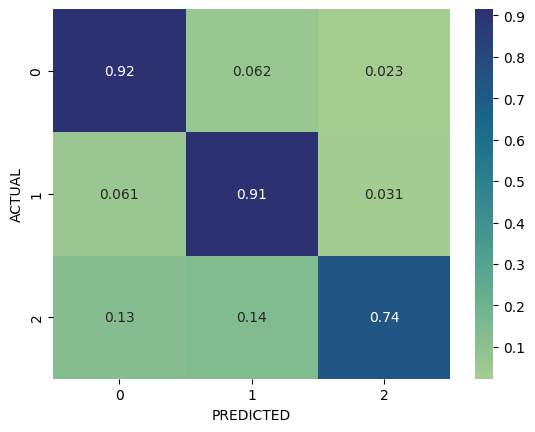

In [56]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('PREDICTED'),
plt.ylabel('ACTUAL');

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # mount once

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
model.save('/content/drive/MyDrive/Saved model/my_model.keras') ### Save the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # mount again for load the model

### Before Load the Model Import all the Libraries

In [49]:
# Load the Preprocessed Data
X_train = np.load('/content/drive/MyDrive/Saved model/X_train.npy')
X_test = np.load('/content/drive/MyDrive/Saved model/X_test.npy')
y_train = np.load('/content/drive/MyDrive/Saved model/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Saved model/y_test.npy')

In [50]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Saved model/my_model.keras')

In [51]:
# Chech the model accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8986 - loss: 0.5600
Model Accuracy : 89.34069871902466
